# Team 6 Project: MINJUSTICIA

In [120]:
import pandas as pd
import numpy as np
import re
from textdistance import levenshtein
import seaborn as sns
import powerlaw as plw
import networkx as nx
import community as community_louvain
import plotly.graph_objects as go
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora, models

path = "C:/Users/david/Desktop/ds4a-team6/retomintic/Data_UpdateJune13/reincidencia11junio2020_clean.csv"
df_mj = pd.read_csv(path, sep=",",encoding="utf-8")

# Análisis de los crímenes

Para estudiar cómo se relacionan los crímenes entre sí 

- se calcularon la cantidad de veces que alguien cometió un delito

- luego se calculó la matriz de correlación entre estos crímenes

- definimos una distancia, al normalizar la correlación para que estuviera acotada inferiormente, como $$d_{ij} = \max(cor_{ij}) - cor_{ij}$$

- con ésta, definimos una medida de similaridad dada por $$s_{ij} = 1 - \frac{d_{ij}}{\max(d_{ij})}$$ 

- decimos que dos crímenes $\left[c_{i}, \enspace c_{j}\right]$ (dos nodos) están relacionados cuando $$d_{ij} < \tau$$ donde $\tau$ es un umbral arbitrario

- el umbral óptimo $\tau^*$ es aquel que hace que el grafo sea libre de escala; esto es, $$p(k) = k^{-\lambda}, \text{ donde $\lambda$ está entre 3 y 2, y $k$ es la proporción de nodos de grado $k$}$$

- a este grafo de delitos $$G = \{[c_i], \enspace 1[d_{ij} < \tau^*]\}$$ podemos hacerle análisis de comunidades y ver cuáles son los delitos más relacionados entre sí

In [121]:
crime = df_mj[['INTERNOEN', 'DELITO']]
crime = crime.groupby(['INTERNOEN', 'DELITO']).size().reset_index()
crime.columns = ['id', 'crime', 'count']
crime = crime.pivot(index='id', columns='crime', values = 'count').fillna(0)
corr = crime.corr()

In [122]:
edge_dict = {}
h = 0
for i in np.arange(corr.shape[0]):
    for  j in np.arange(corr.shape[1]):
        if i > j:
            edge_dict[h] = [corr.columns[i], corr.columns[j], corr.iloc[i, j]]
        h+=1

pd_edges = pd.DataFrame.from_dict(edge_dict).T
pd_edges.columns = ['source', 'target', 'weight']
pd_edges['weight'] = pd_edges['weight'].astype(float)
pd_edges.weight = (pd_edges.weight.max() - pd_edges.weight)

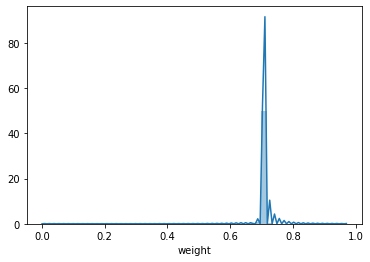

In [123]:
sns.distplot(pd_edges.weight)

In [124]:
grid = np.linspace(0.6, 0.7, num = 161)

def free_scale(t):
    pd_edges['reduced_weight'] = pd_edges.weight
    pd_edges.loc[pd_edges.weight > t, 'reduced_weight'] = 0
    pd_edges['similarity'] = 1 - pd_edges.reduced_weight/pd_edges.reduced_weight.max()
    pd_edges.loc[pd_edges.similarity == 1, 'similarity'] = 0
    graph = nx.from_pandas_edgelist(pd_edges.loc[pd_edges.similarity > 0, ['source', 'target', 'weight']])
    degree_sequence = sorted([b for a, b in graph.degree()], reverse = True)
    fit = plw.Fit(degree_sequence)
    return(fit.power_law.alpha)

result = map(free_scale, grid)

alpha = pd.Series(result)

Calculating best minimal value for power law fit
C:\Users\david\AppData\Local\Continuum\anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning:

invalid value encountered in true_divide

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal

2.4032382285775817


Calculating best minimal value for power law fit


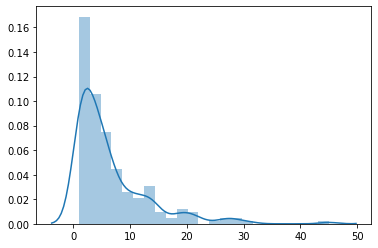

In [125]:
distance_threshold = grid[alpha == min(alpha)][0]

pd_edges['reduced_weight'] = pd_edges.weight
pd_edges.loc[pd_edges.weight > distance_threshold, 'reduced_weight'] = 0
pd_edges['similarity'] = 1 - pd_edges.reduced_weight/pd_edges.reduced_weight.max()
pd_edges.loc[pd_edges.similarity == 1, 'similarity'] = 0

graph = nx.from_pandas_edgelist(pd_edges.loc[pd_edges.similarity > 0, ['source', 'target', 'weight']])
degree_sequence = sorted([b for a, b in graph.degree()], reverse = True)
fit = plw.Fit(degree_sequence)

print(fit.power_law.alpha)

sns.distplot(degree_sequence)

In [126]:
edges_result = pd_edges.loc[pd_edges.similarity > 0, ['source', 'target', 'similarity']]

partition = community_louvain.best_partition(graph)

nodes_result = pd.DataFrame.from_dict(partition.items())
nodes_result.columns = ['Id', 'community'] 
nodes_result['label'] = nodes_result['Id']

In [127]:
nodes_result['name'] = nodes_result['label'].apply(lambda x: [word for word in word_tokenize(x.lower()) if word not in stopwords.words('spanish')])

cluster_topic = {}
for number in nodes_result.community.unique():
    docs = nodes_result.loc[nodes_result.community == number, 'name']
    dictionary = gensim.corpora.Dictionary(docs)
    bow_corpus = [dictionary.doc2bow(doc) for doc in docs]

    tfidf = models.TfidfModel(bow_corpus)
    corpus_tfidf = tfidf[bow_corpus]

    lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=3, id2word=dictionary, passes=2, workers=4)
    cluster_topic[number] = ', '.join(['-'.join([word[0][0], word[1][0]]) for topic, word in lda_model_tfidf.show_topics(formatted=False,num_words=2)])
    
topics = pd.DataFrame.from_dict(cluster_topic.items())
topics.columns = ['community', 'topic']
nodes_result = nodes_result.merge(topics, on = 'community')

In [133]:
graph = nx.from_pandas_edgelist(edges_result, source = 'source', target = 'target', edge_attr = 'similarity')

pos_ = nx.spring_layout(graph)
edge_x = []
edge_y = []

for edge in graph.edges():
    
    if graph.edges()[edge]['similarity'] > 0:
        char_1 = edge[0]
        char_2 = edge[1]
        x0, y0 = pos_[char_1]
        x1, y1 = pos_[char_2]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
        
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
community = []
crime_label = []
for node in graph.nodes():
    x, y = pos_[node]
    node_x.append(x)
    node_y.append(y)
    community.append(*nodes_result.loc[nodes_result.Id == node, 'community'].values)
    com = nodes_result.loc[nodes_result.Id == node, 'topic'].values[0]
    label = f'''{node}: {com}'''
    crime_label.append(label)

node_trace = go.Scatter(
    x= node_x, y= node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale = True,
        color=community,
        size=10,
        line_width=2),
    text = crime_label)

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Relación entre crímenes <br>',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.show()